<h1 style="text-align:center; font-size: 50px; margin: 0; font-weight: 300; margin-bottom: 5px">Exoplanets Homework 3 - Tom Wagg</h1>
<h3 style="text-align:center; font-size: 25px; font-style: italic; font-weight: 100; margin: 0; margin-bottom: 10px">It's TTV Time</h3>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

import astropy.units as u
import astropy.constants as const

import rebound

from scipy.optimize import curve_fit

In [6]:
# remember this old chestnut?
sys.path.append("../pset1")
from planet_finder import radial_velocity

In [7]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Contents
- [Problem 1](#p1)
- [Problem 2](#p2)
- [Problem 3](#p3)
- [Problem 4](#p4)

<h1><a id="p1">Problem 1</a></h1>

*Install the dynamical integrator REBOUND using Python:https://rebound.readthedocs.io/en/latest/. Look through the examplenotebooks, and familiarize yourself with initializing and running a planetary system. [2 pt]*

<hr>

In [8]:
rebound.__version__

'3.19.3'

Okay rebound is installed, let's run a test simulation!

In [9]:
sim = rebound.Simulation()

sim.add(m=1.)                # Central object
sim.add(m=1e-3, a=1., e=0.1) # Jupiter mass planet 
sim.add(a=1.4, e=0.1)        # Massless test particle

sim.integrate(100.)

for p in sim.particles:
    print(p.x, p.y, p.z)
for o in sim.calculate_orbits(): 
    print(o)

0.0001379031111733169 0.11100285684422287 0.0
0.7620968888266642 -0.3934338982350228 0.0
-1.5948501191422428 0.20487096187200812 0.0
<rebound.Orbit instance, a=0.9999999999999998 e=0.10000000000000006 inc=0.0 Omega=0.0 omega=0.0 f=5.698402270529936>
<rebound.Orbit instance, a=1.4174273398342736 e=0.12988282793113465 inc=0.0 Omega=0.0 omega=0.09938842199489617 f=2.9831333920230048>


Looks good to me!

<h1><a id="p2">Problem 2</a></h1>

*Look up the parameters of the multi-transiting planet system Kepler-289c/d (aka Planethunters 3; ignore planet b). Assume the planets’ orbits lie in a plane, and vary the inclination of the system (so that it would not transit). Pretend that the masses were detected with RV (they were actually measured with TTVs!), so that as you incline the orbit, the planet masses increase as $(sin \iota)^{−1}$. At what inclination does the system become unstable after $10^3$ orbits of the inner planet?*

*What upper limit would this place on the planets’ masses if they were measured with RV rather than TTV?*

<hr>

### Set up Kepler 289c

We can find the data for Kepler-289 here: http://www.openexoplanetcatalogue.com/planet/Kepler-289%20c/

In [10]:
kepler289star = {
    "mass": 1.08 * u.Msun,
    "radius": 1.00 * u.Rsun
}

kepler289d = {
    "mass": 0.013 * u.Mjup,
    "radius": 0.239 * u.Rjup,
    "a": 0.33 * u.AU
}

kepler289c = {
    "mass": 0.41 * u.Mjup,
    "radius": 1.034 * u.Rjup,
    "a": 0.51 * u.AU
}

kepler289_system = [kepler289star, kepler289d, kepler289c]

Let's use that data to create a REBOUND simulation and produce a fancy plot.

In [11]:
def create_kepler289_sim(inv_sini=1):
    # start simulation, adjust units
    sim = rebound.Simulation()
    sim.units = ("yr", "AU", "Msun")

    sim.add(m=kepler289star["mass"].to(u.Msun).value, r=kepler289star["radius"].to(u.AU).value)
    sim.add(m=kepler289d["mass"].to(u.Msun).value * inv_sini, r=kepler289d["radius"].to(u.AU).value, a=kepler289d["a"].to(u.AU).value)
    sim.add(m=kepler289c["mass"].to(u.Msun).value * inv_sini, r=kepler289c["radius"].to(u.AU).value, a=kepler289c["a"].to(u.AU).value)
    sim.move_to_com()
    
    return sim

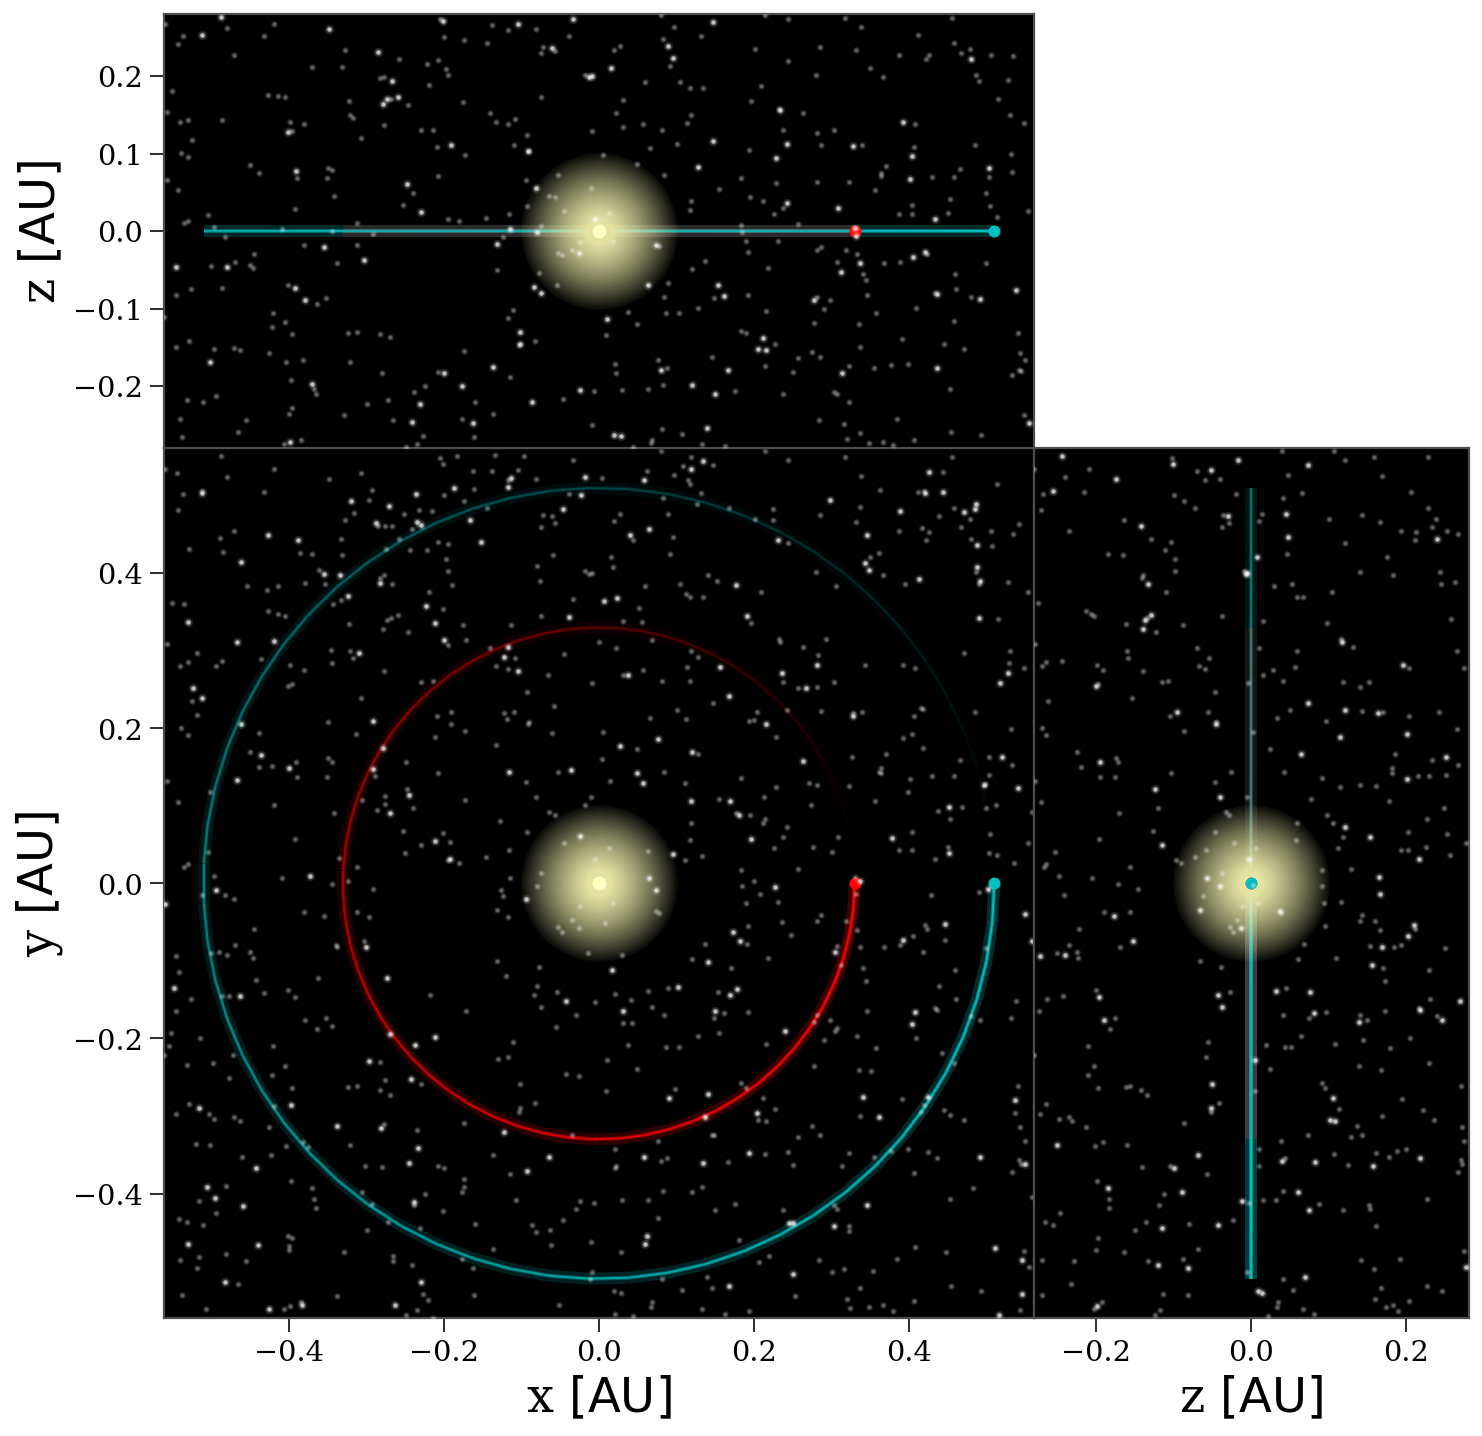

In [12]:
sim = create_kepler289_sim()

fig, ax, _, _ = rebound.OrbitPlot(sim, unitlabel=r"$[\rm AU]$", color=True, fancy=True, slices=0.5, figsize=(12, 12))

### Find minium inclination
So now we have the REBOUND simulation set up, let's start cranking the inclination down and see how low we can put it (and thus how high we can make the masses) before the whole thing gets unstable.

First let's just make a quick function to calculate the total angular momentum of a simulation because it'll be useful for assessing stability

In [13]:
def calc_ang_mom(sim):
    ang_mom = 0
    for particle in sim.particles:
        r = np.sqrt(particle.x**2 + particle.y**2 + particle.z**2)
        v = np.sqrt(particle.vx**2 + particle.vy**2 + particle.vz**2)
        ang_mom += particle.m * v * r
    return ang_mom

Now let's talk about stability, I have 3 criteria in my function which claims instability if:

1. An orbit has crossed (i.e. the planets have swapped order)
2. An orbit is not closed (bye bye planet)
3. Angular momentum was not conserved (just in case)

In [14]:
def assess_stability(final_orbits, original_ang_mom, final_ang_mom, verbose=False):
    # check that orbits did not cross
    if final_orbits[0].a > final_orbits[1].a:
        if verbose:
            print("Orbits crossed!")
        return False
    
    # check that orbits are closed
    for orbit in final_orbits:
        if orbit.a < 0 or orbit.e > 1:
            if verbose:
                print("An orbit is not closed!")
            return False
        
    # check angular momentum has been conserved
    if final_ang_mom / original_ang_mom > 1.01:
        if verbose:
            print("Angular momentum was not conserved!")
        return False
    
    return True

I'm going to change the value of $(\sin i)^{-1}$ (=`inv_sini`) because that seems easier and just binary search the region down. I did some preliminary tests and found it was unstable by the time this factor reaches 95 and we can search between 1 and 95.

In [15]:
inv_sini_lims = [1, 95]
while inv_sini_lims[1] - inv_sini_lims[0] > 0.001:
    inv_sini = np.mean(inv_sini_lims)
    sim = create_kepler289_sim(inv_sini)
    original_ang_mom = calc_ang_mom(sim).round(4)

    sim.integrate(1000 * sim.particles[1].P)

    final_orbits = sim.calculate_orbits()
    final_ang_mom = calc_ang_mom(sim).round(4)

    if assess_stability(final_orbits, original_ang_mom, final_ang_mom, verbose=False):
        inv_sini_lims[0] = inv_sini
    else:
        inv_sini_lims[1] = inv_sini
    
    print(f"Remaining range [{inv_sini_lims[0]:1.3f}, {inv_sini_lims[1]:1.3f}]")

Remaining range [48.000, 95.000]
Remaining range [71.500, 95.000]
Remaining range [83.250, 95.000]
Remaining range [89.125, 95.000]
Remaining range [89.125, 92.062]
Remaining range [90.594, 92.062]
Remaining range [90.594, 91.328]
Remaining range [90.961, 91.328]
Remaining range [90.961, 91.145]
Remaining range [90.961, 91.053]
Remaining range [90.961, 91.007]
Remaining range [90.984, 91.007]
Remaining range [90.995, 91.007]
Remaining range [91.001, 91.007]
Remaining range [91.001, 91.004]
Remaining range [91.003, 91.004]
Remaining range [91.003, 91.004]


We can take that factor and convert it to a minimum inclination!

In [16]:
minimum_inc = np.arcsin(1 / inv_sini)

### Now let's make some RV "measurements"
First run a sim with Kepler289 and record a bunch of RV measurements (it seems good time resolution is important to make this look smooth)

[RV Example in REBOUND](https://rebound.readthedocs.io/en/latest/ipython_examples/RadialVelocity/)

In [17]:
def get_rvs(sim, n_steps=100000):
    original_ang_mom = calc_ang_mom(sim).round(4)

    max_time = 1000 * sim.particles[1].P
    timesteps = np.linspace(0, max_time, n_steps)

    rvs = np.zeros(n_steps)
    for i, t in enumerate(timesteps):
        sim.integrate(t)
        rvs[i] = sim.particles[0].vx
        
    return timesteps, rvs

In [18]:
sim = create_kepler289_sim()
timesteps, rvs = get_rvs(sim)

Let's take a quick look at these RVs just to get an impression (just looking at the first 20% of the data because it's too dense otherwise)

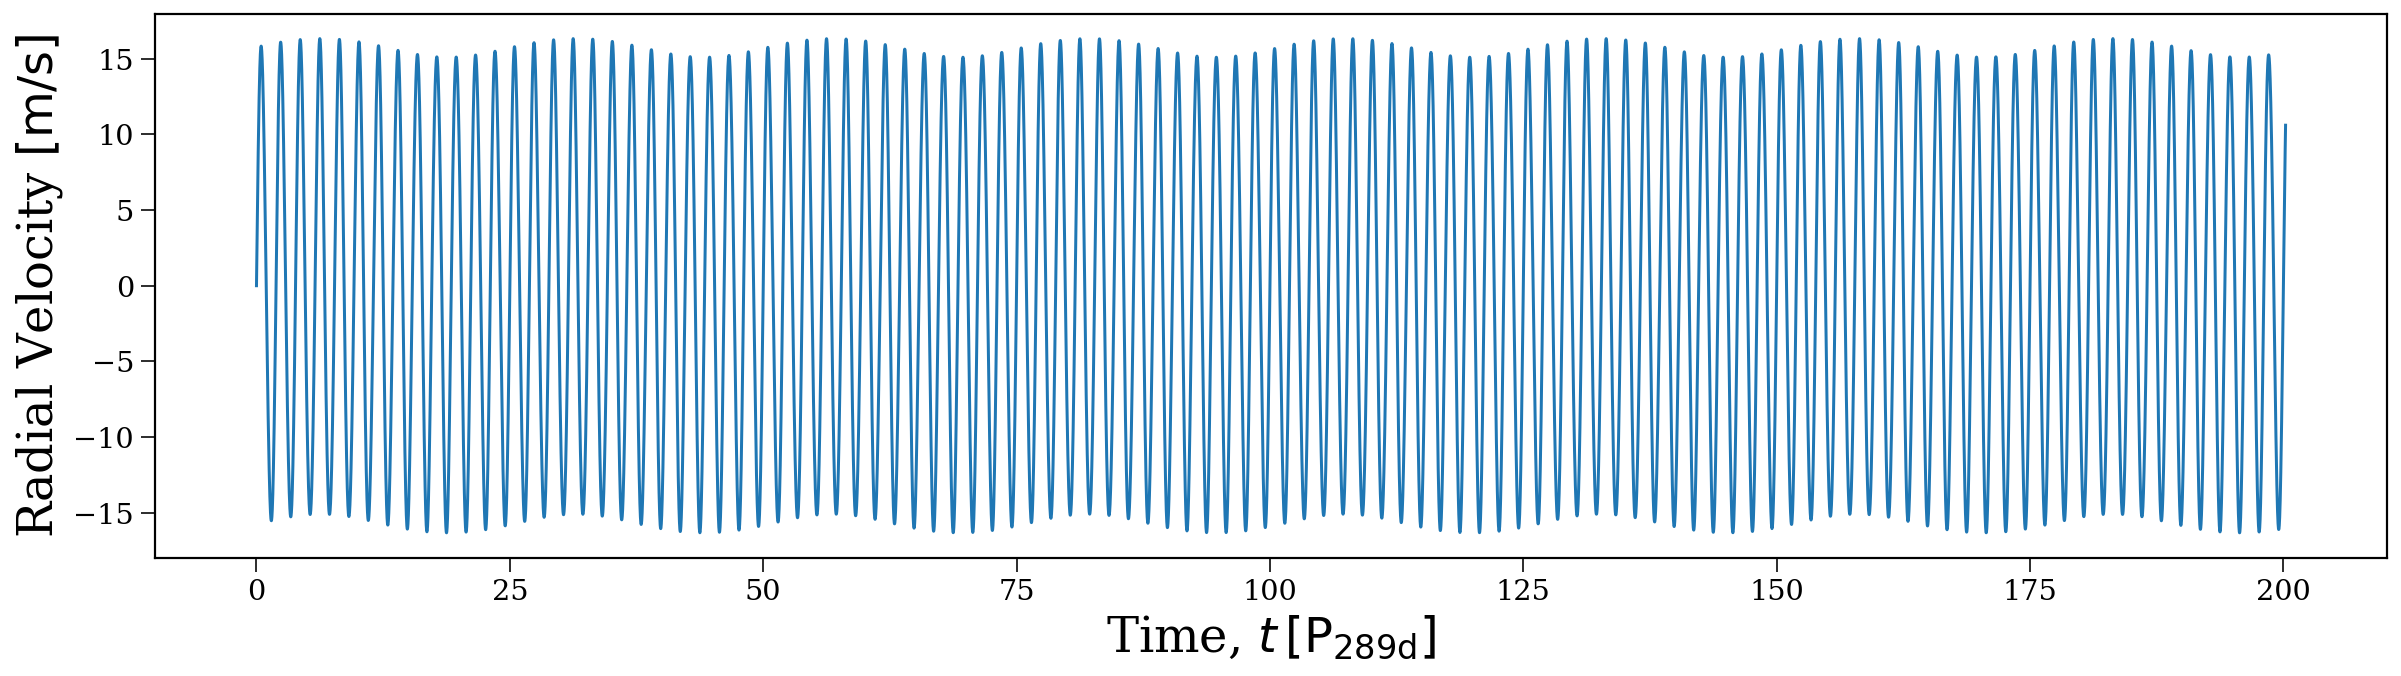

In [19]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(timesteps[:20000] / sim.particles[1].P, (rvs[:20000] * u.AU / u.yr).to(u.m / u.s))

ax.set_xlabel(r"Time, $t \, [\rm P_{\rm 289d}]$")
ax.set_ylabel(r"Radial Velocity $[\rm m / s]$")

plt.show()

Next we're going to use scipy to fit sinusoids to this data.

In [20]:
def sin_fit(x, P, kstar, c):
    return kstar * np.sin(x * 2 * np.pi / P - c)

In [21]:
kstar_outer = 0.5 * (rvs.max() - rvs.min())
outer_fit = curve_fit(sin_fit, xdata=timesteps, ydata=rvs, p0=[sim.particles[2].P, kstar_outer, 0])[0]

Now we remove the fitted outer planet and get a fit for the inner planet

In [22]:
remaining_rvs = rvs - sin_fit(timesteps, *outer_fit)
kstar_inner = 0.5 * (remaining_rvs.max() - remaining_rvs.min())
inner_fit = curve_fit(sin_fit, xdata=timesteps, ydata=remaining_rvs, p0=[sim.particles[1].P, kstar_inner, 0])[0]

Finally, we can convert these to values of $M_p \sin i$ for each planet.

In [23]:
def get_Mp_sini(kstar, P, Ms=kepler289star["mass"], e=0):
    return (kstar / (2 * np.pi * const.G / (P * (1 - e**2)))**(1/3) * Ms**(2/3)).to(u.Mjup)

In [24]:
P_out_fit, kstar_out_fit, _ = outer_fit
P_in_fit, kstar_in_fit, _ = inner_fit

In [25]:
max_mass_outer = get_Mp_sini(kstar_out_fit * u.AU / u.yr, P_out_fit * u.yr, kepler289star["mass"]) / np.sin(minimum_inc)
max_mass_inner = get_Mp_sini(kstar_in_fit * u.AU / u.yr, P_in_fit * u.yr, kepler289star["mass"]) / np.sin(minimum_inc)

## Answer for Problem 2

So in summary we find that the maximum mass can be constrained for each planet as follows

In [26]:
RED = "\033[0;31m"
BOLD = "\033[1m"
END = "\033[0m"

In [27]:
print(f"Kepler289-d can be at most {BOLD}{max_mass_inner:1.1f}{END}")
print(f"Kepler289-c can be at most {BOLD}{max_mass_outer:1.1f}{END}")

Kepler289-d can be at most 1.2 jupiterMass
Kepler289-c can be at most 37.3 jupiterMass


<h1><a id="p3">Problem 3</a></h1>

*Simulate the edge-on radial velocity of the star, and then fit this RV with two Keplerian orbits. How big are the residuals? How does this compare to typical RV errors?*

<hr>

Let's use scipy again to fit two keplerian orbits to these RVs. We're going to assume $\gamma = 0$ for both but then fit $k^*$, $\omega$, $e$, $t_p$, and $P$ for each planet.

In [28]:
def two_planet_rv(t, k_star_1, omega_1, e_1, t_p_1, P_1, k_star_2, omega_2, e_2, t_p_2, P_2):
    gamma = 0
    if isinstance(t, (list, np.ndarray)):
        rv_1 = np.array([radial_velocity(k_star=k_star_1, omega=omega_1,
                                         e=e_1, t=tt, t_p=t_p_1, P=P_1, gamma=gamma) for tt in t])
        rv_2 = np.array([radial_velocity(k_star=k_star_2, omega=omega_2,
                                         e=e_2, t=tt, t_p=t_p_2, P=P_2, gamma=gamma) for tt in t])
    else:
        rv_1 = radial_velocity(k_star=k_star_1, omega=omega_1, e=e_1, t=t, t_p=t_p_1, P=P_1, gamma=gamma)
        rv_2 = radial_velocity(k_star=k_star_2, omega=omega_2, e=e_2, t=t, t_p=t_p_2, P=P_2, gamma=gamma)
        
    return rv_1 + rv_2

Let's quickly redo the RVs but this time with fewer timesteps to speed things up

In [29]:
timesteps, rvs = get_rvs(sim, 10000)

In [30]:
fits, _ = curve_fit(two_planet_rv, timesteps, rvs,
                        p0=[kstar_out_fit, 0, 0, 0, P_out_fit, kstar_in_fit, 0, 0, 0, P_in_fit],
                        bounds=([kstar_out_fit * 0.8, 0, 0, 0, P_out_fit * 0.8,
                                 kstar_in_fit * 0.8, 0, 0, 0, P_in_fit * 0.8],
                                [kstar_out_fit * 1.2, 2 * np.pi, 1, P_out_fit * 1.2, P_out_fit * 1.2,
                                 kstar_in_fit * 1.2, 2 * np.pi, 1, P_in_fit * 1.2, P_in_fit * 1.2]
                               )
                    )

Now that we're done fitting we can cheat and add the timesteps back and plot the difference between the fit and the data.

In [31]:
timesteps, rvs = get_rvs(sim, 100000)

In [32]:
residuals = (two_planet_rv(timesteps, *fits) - rvs) * u.AU / u.yr

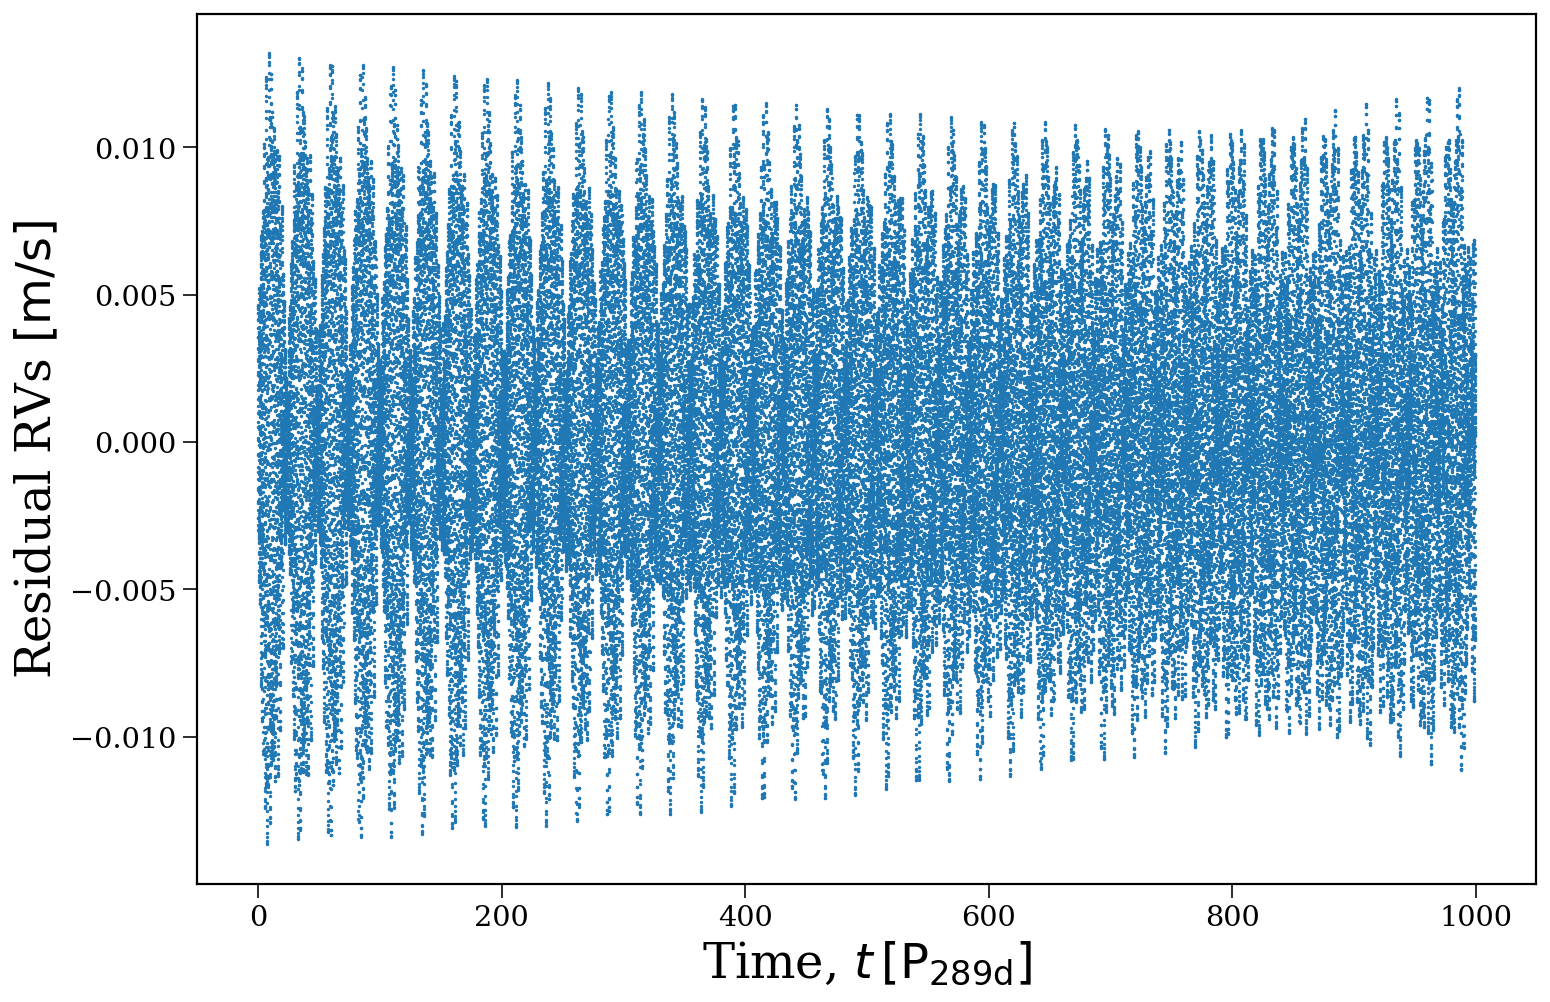

In [33]:
fig, ax = plt.subplots()

ax.scatter(timesteps / sim.particles[1].P, residuals.to(u.m / u.s), s=0.5)

ax.set_xlabel(r"Time, $t \, [\rm P_{\rm 289d}]$")
ax.set_ylabel(r"Residual RVs $[\rm m / s]$")

plt.show()

These residuals are **much** lower than what we can measure with RVs. If only there was another way to measure the signal of this planet...oh look problem 4!

<h1><a id="p4">Problem 4</a></h1>

*Look at [REBOUND TTV example](https://rebound.readthedocs.io/en/latest/ipython_examples/TransitTimingVariations/). Make a plot of the TTVs of Kepler-289c/d over 4 years (assuming edge-on, so that planets do in fact transit). Measure amplitude and period of the sinusoidal variation component. How does it change if you vary the mass of Kepler-289d downward and upward by a factor of 2?*

<hr>

## Plot TTVs

Okay let's start by just plotting the TTVs for each planet. First we need two functions, one calculates the transit times and the other removes the linear trend to give us the sinusoial variation.

In [35]:
def get_TTVs(sim, which=1, precision=1e-7, n_transits=100, outer_mass_factor=None):
    # set up time array and use a particle shorthand
    transit_times = np.zeros(n_transits)
    p = sim.particles
    
    if outer_mass_factor is not None:
        sim.particles[2].m *= outer_mass_factor
    
    # find the period for timestepping
    period = sim.particles[which].P
    
    i = 0
    while i < n_transits:
        y_old = p[which].y - p[0].y
        t_old = sim.t
        
        # check for transits every 0.1 periods
        sim.integrate(sim.t + period / 10)
        y_new = p[which].y - p[0].y
        t_new = sim.t

        # check if y changed sign and whether planet is in front
        if np.sign(y_old) != np.sign(y_new) and p[which].x - p[0].x > 0:
            # drill down timesteps until we are right on the transit
            while t_new - t_old > precision:
                y_new = p[which].y - p[0].y
                if np.sign(y_old) != np.sign(y_new):
                    t_new = sim.t
                else:
                    t_old = sim.t
                sim.integrate(0.5 * (t_new + t_old))
                
            # record the transit time
            transit_times[i] = sim.t
            i += 1
            
            # integrate just past the transit
            sim.integrate(sim.t + period / 100)
            
    return transit_times

In [36]:
def remove_linear_comp(transit_times):
    n_transits = len(transit_times)
    A = np.vstack([np.ones(n_transits), range(n_transits)]).T
    c, m = np.linalg.lstsq(A, transit_times, rcond=-1)[0]
    return transit_times - (m * np.arange(n_transits) + c)

Now we can use these functions to get the TTVs for both the inner and the outer planet

In [37]:
sim = create_kepler289_sim()

transit_times_inner = get_TTVs(sim, which=1)
transit_times_inner = remove_linear_comp(transit_times_inner) * u.yr

sim = create_kepler289_sim()
transit_times_outer = get_TTVs(sim, which=2)
transit_times_outer = remove_linear_comp(transit_times_outer) * u.yr

Let's plot those out and highlight the two main periodic variations.

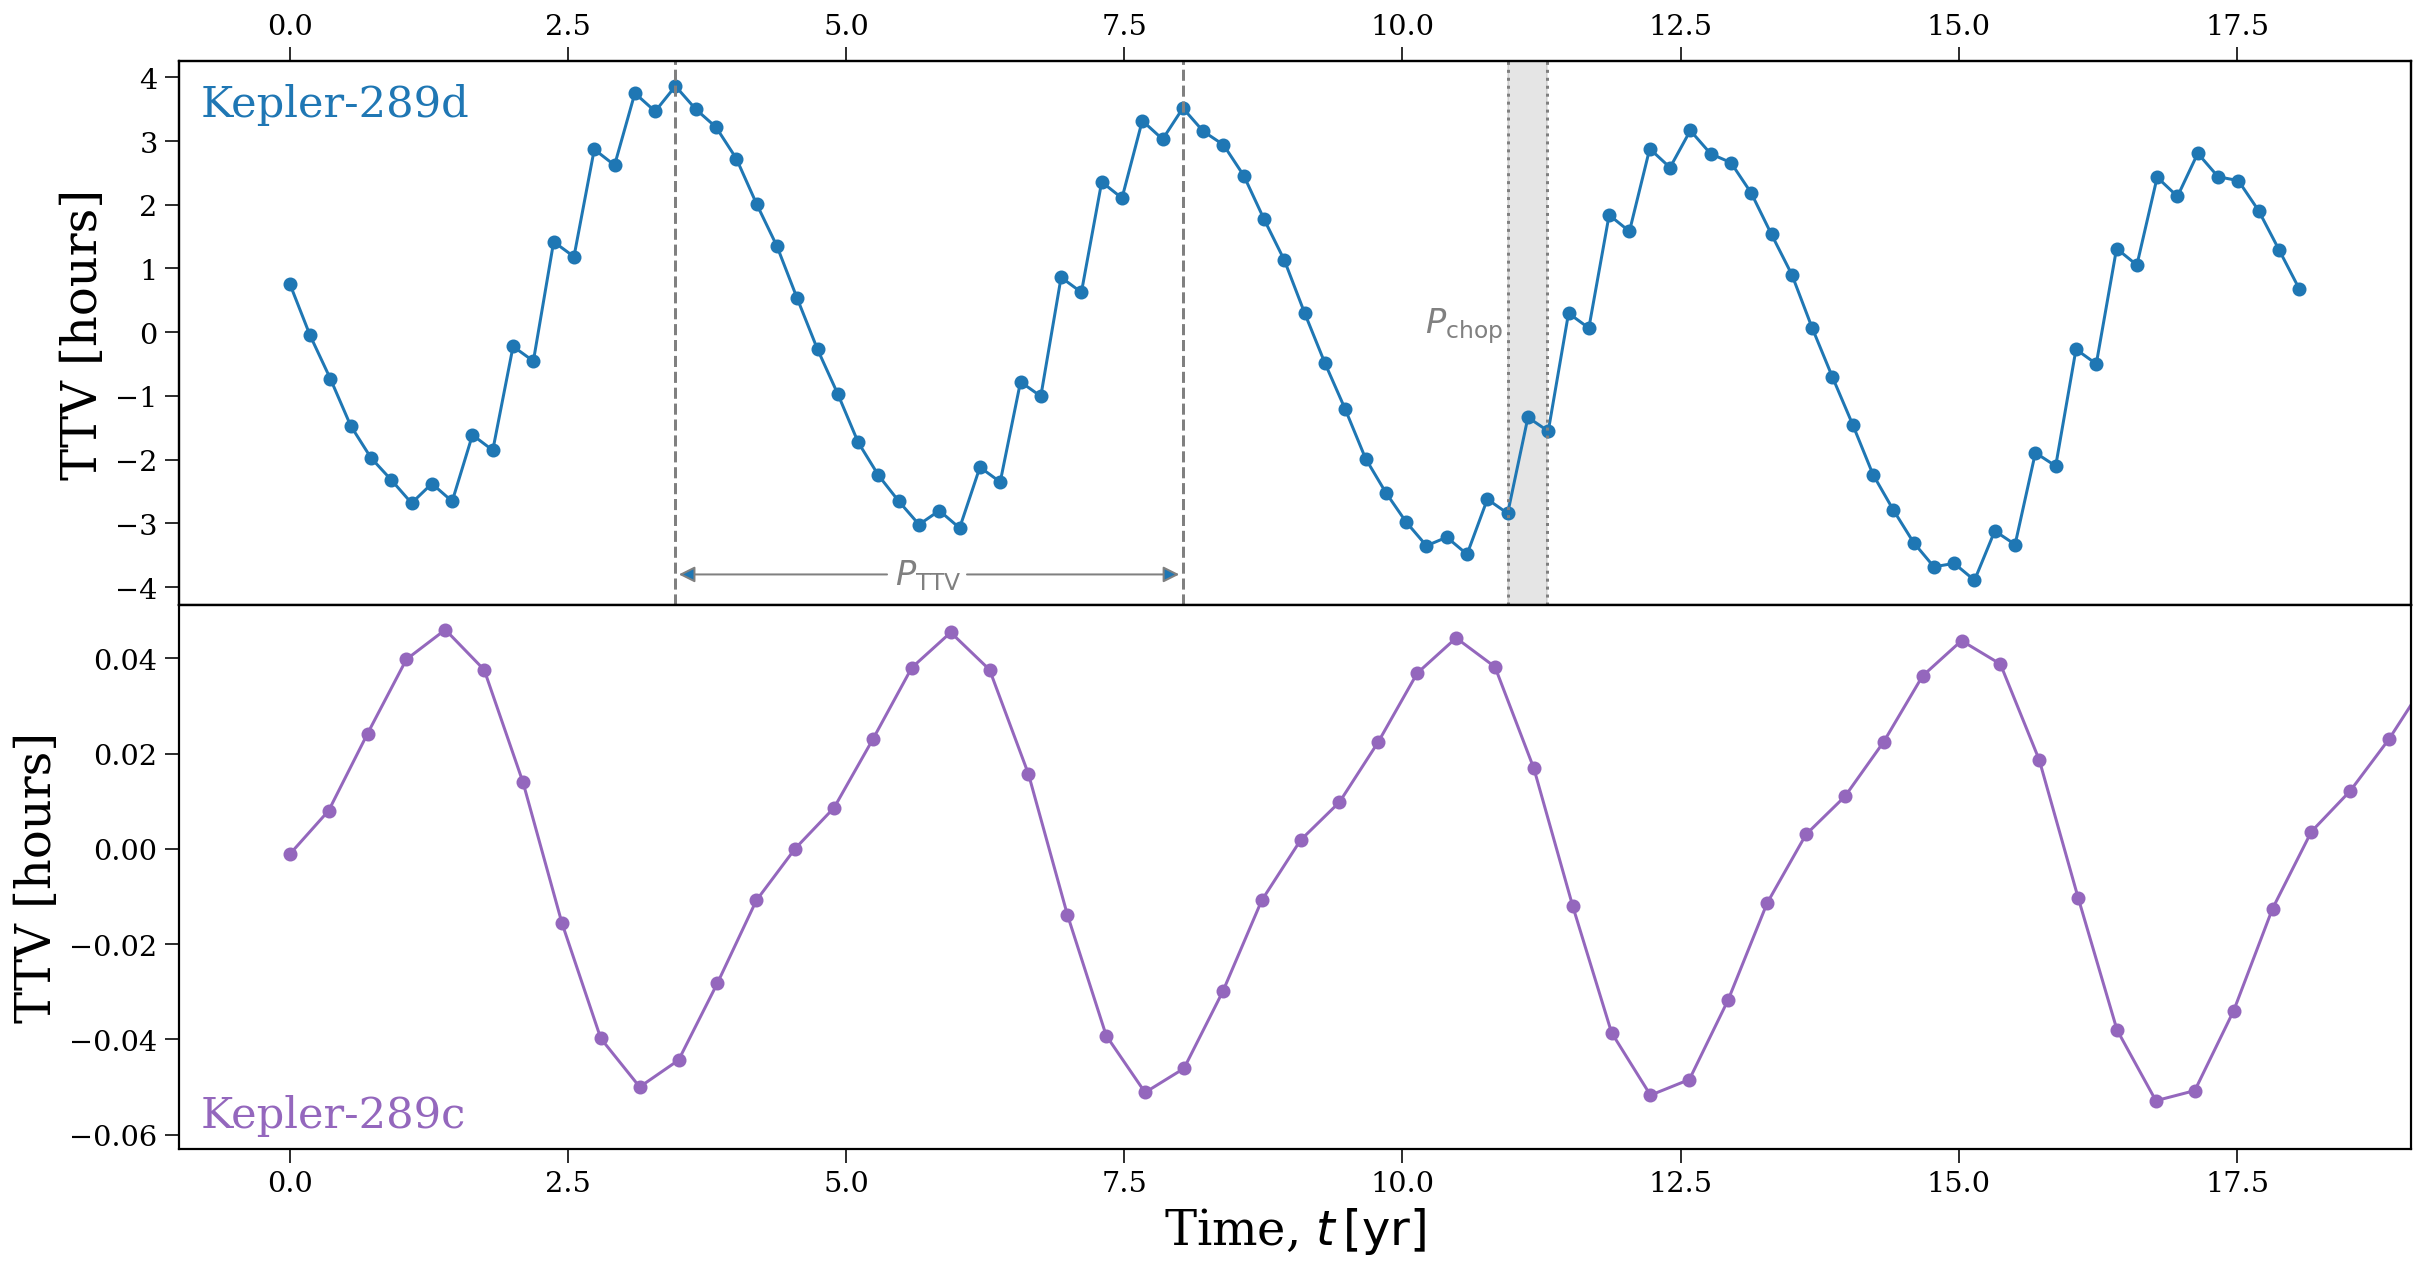

In [56]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
fig.subplots_adjust(hspace=0)

times_inner = np.arange(len(transit_times_inner)) * sim.particles[1].P 
times_outer = np.arange(len(transit_times_outer)) * sim.particles[2].P 
axes[0].plot(times_inner, transit_times_inner.to(u.hour), marker="o")
axes[1].plot(times_outer, transit_times_outer.to(u.hour), marker="o", color="tab:purple")

axes[1].set_xlim(-1, right=np.max(times_inner) + 1)

top_ax = axes[0].twiny()
top_ax.set_xlim(axes[1].get_xlim())

axes[1].set_xlabel(r"Time, $t \, [\rm yr]$")

for ax in axes:
    ax.set_ylabel("TTV [hours]")
    
axes[0].annotate("Kepler-289d", xy=(0.01, 0.96), xycoords="axes fraction", fontsize=0.9 * fs, color="tab:blue", va="top")
axes[1].annotate("Kepler-289c", xy=(0.01, 0.04), xycoords="axes fraction", fontsize=0.9 * fs, color="tab:purple")

axes[0].axvline(10.95, color="grey", linestyle="dotted")
axes[0].axvline(11.3, color="grey", linestyle="dotted")
axes[0].axvspan(10.95, 11.3, color="grey", alpha=0.2)
axes[0].annotate(r"$P_{\rm chop}$", xy=(10.9, 0), ha="right", fontsize=0.7 * fs, color="grey")

axes[0].axvline(3.46, color="grey", linestyle="--")
axes[0].axvline(8.03, color="grey", linestyle="--")
axes[0].annotate(r"$P_{\rm TTV}$", xy=(3.46, -3.8), xytext=(5.74, -3.8), ha="center", va="center", fontsize=0.7 * fs, color="grey",
                 arrowprops=dict(arrowstyle="-|>", ec="grey"))
axes[0].annotate(r"", xy=(8.03, -3.8), xytext=(6.05, -3.8), ha="center", va="center", fontsize=0.7 * fs, color="grey",
                 arrowprops=dict(arrowstyle="-|>", ec="grey"))

plt.show()

Well that turned out well! Note how the curves almost "mirror" each other as the planets are dancing around the star, nice!

## Mass adjustment effects

But what happens if we start adjusting the mass? We **expect** that increasing the mass of planet c will just shift the amplitude of the TTVs and the period should remain fixed.
### Decreasing mass
Let's start by just decreasing the outer planet's mass linearly and taking a look at the TTVs of the inner planet.

In [64]:
def ttv_plot_mass_factors(factors, cmap="magma"):
    transit_times_list = [None for i in range(len(factors))]
    for i, factor in enumerate(factors):
        sim = create_kepler289_sim()
        transit_times_list[i] = get_TTVs(sim, which=1, outer_mass_factor=factor)
        transit_times_list[i] = remove_linear_comp(transit_times_list[i]) * u.yr
        
    fig, ax = plt.subplots(figsize=(20, 5), sharex=True)

    for i, things in enumerate(zip(factors, transit_times_list)):
        factor, transit_times = things
        times = np.arange(len(transit_times)) * sim.particles[1].P 
        ax.plot(times, transit_times.to(u.hour), marker="o", color=plt.get_cmap(cmap, len(factors) + 2)(i + 1), label=factor)

    leg = ax.legend(title="Kepler289c Mass Factor", fontsize=0.5*fs, ncol=2)
    leg.get_title().set_fontsize(0.6 * fs)

    ax.set_xlabel(r"Time, $t \, [\rm yr]$")
    ax.set_ylabel("TTV [hours]")

    plt.show()

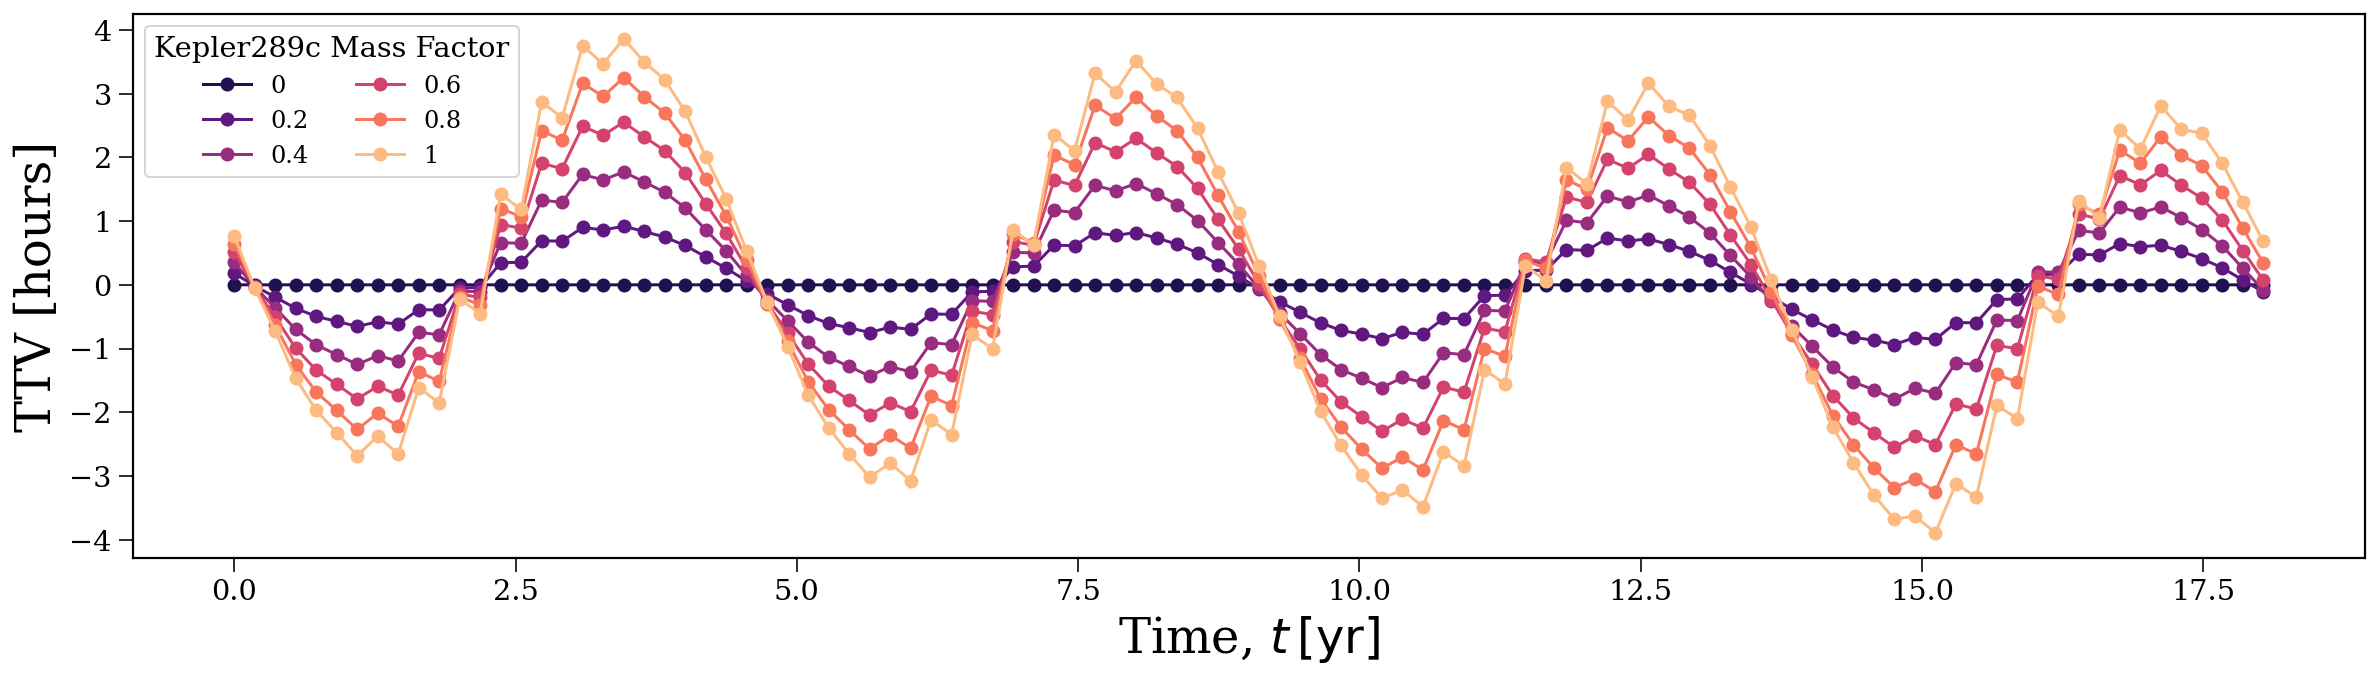

In [65]:
ttv_plot_mass_factors([0, 0.2, 0.4, 0.6, 0.8, 1])

Splendid! As expected, the amplitude of the TTVs seem to depend linearly on the mass of the outer planet, less massive planet = lower amplitude!

### Increasing mass
Okay what about when we increase?

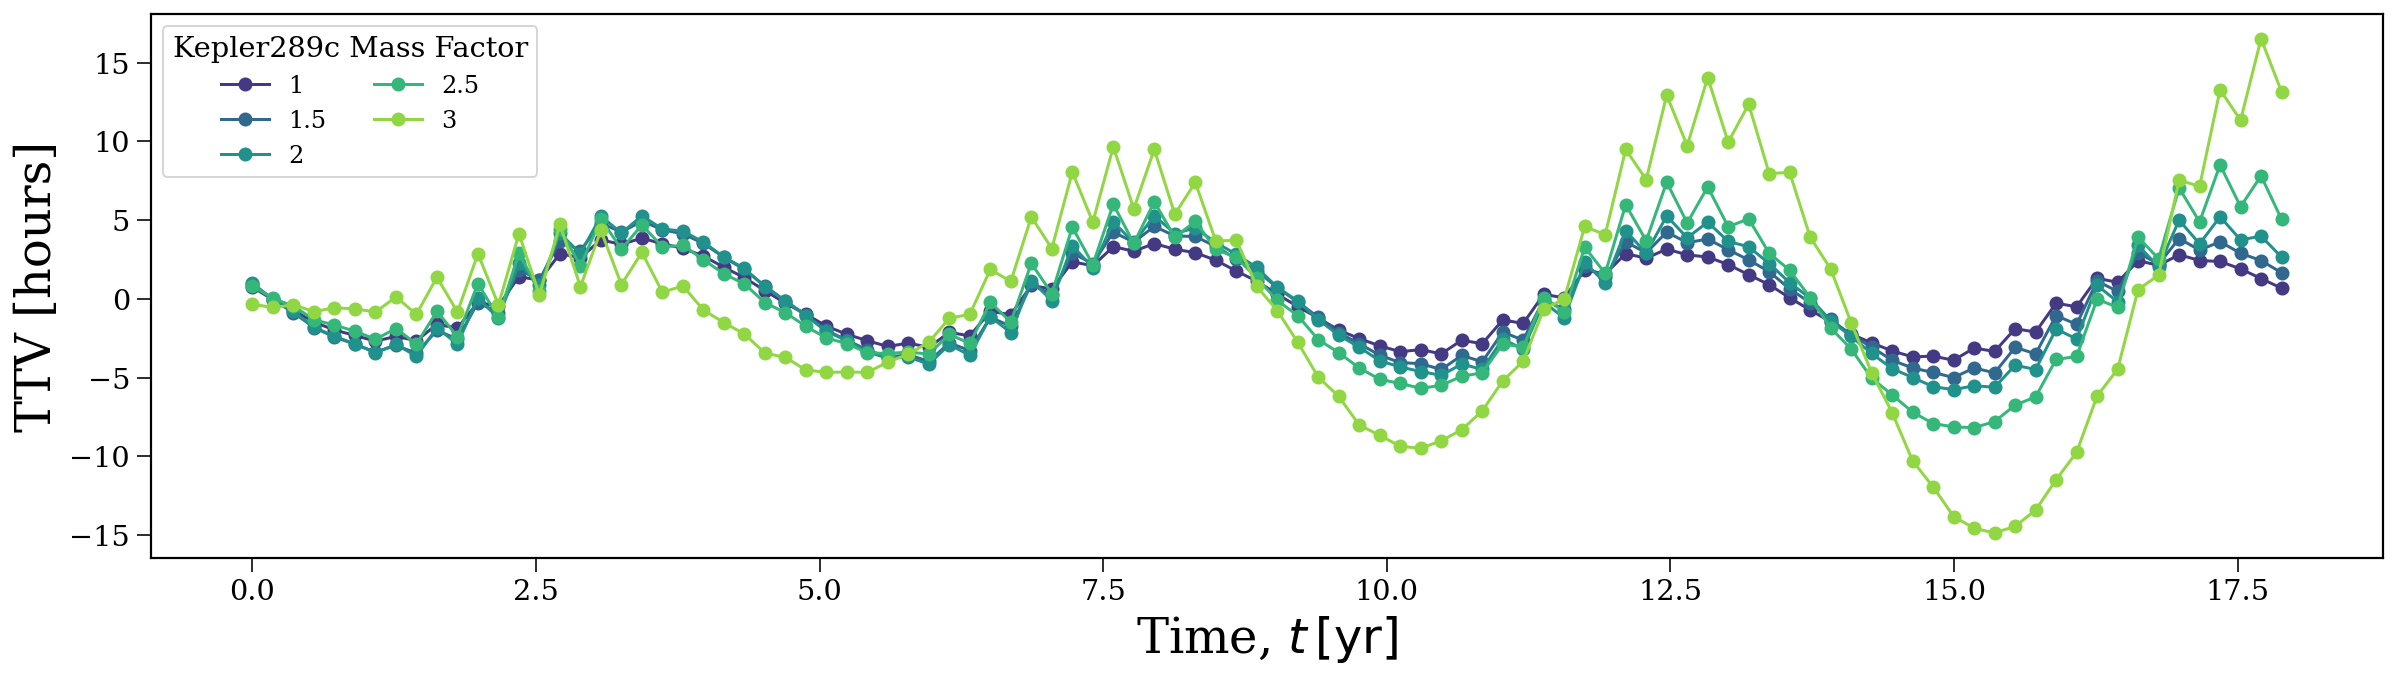

In [62]:
ttv_plot_mass_factors([1, 1.5, 2, 2.5, 3], cmap="viridis")

Well...that's not the same in reverse haha.

I *think* that what is happening here is that the increase mass of the outer planet is enough to start significantly shifting the period of both planets. The period of the TTVs is no longer fixed in what we derived in class and so we're seeing more complex effects. Simply put the outer planet is now starting to have pretty significant influences on the dynamics of both the star and other planet.

We also see dramatic things start happening if we really crank up the mass.

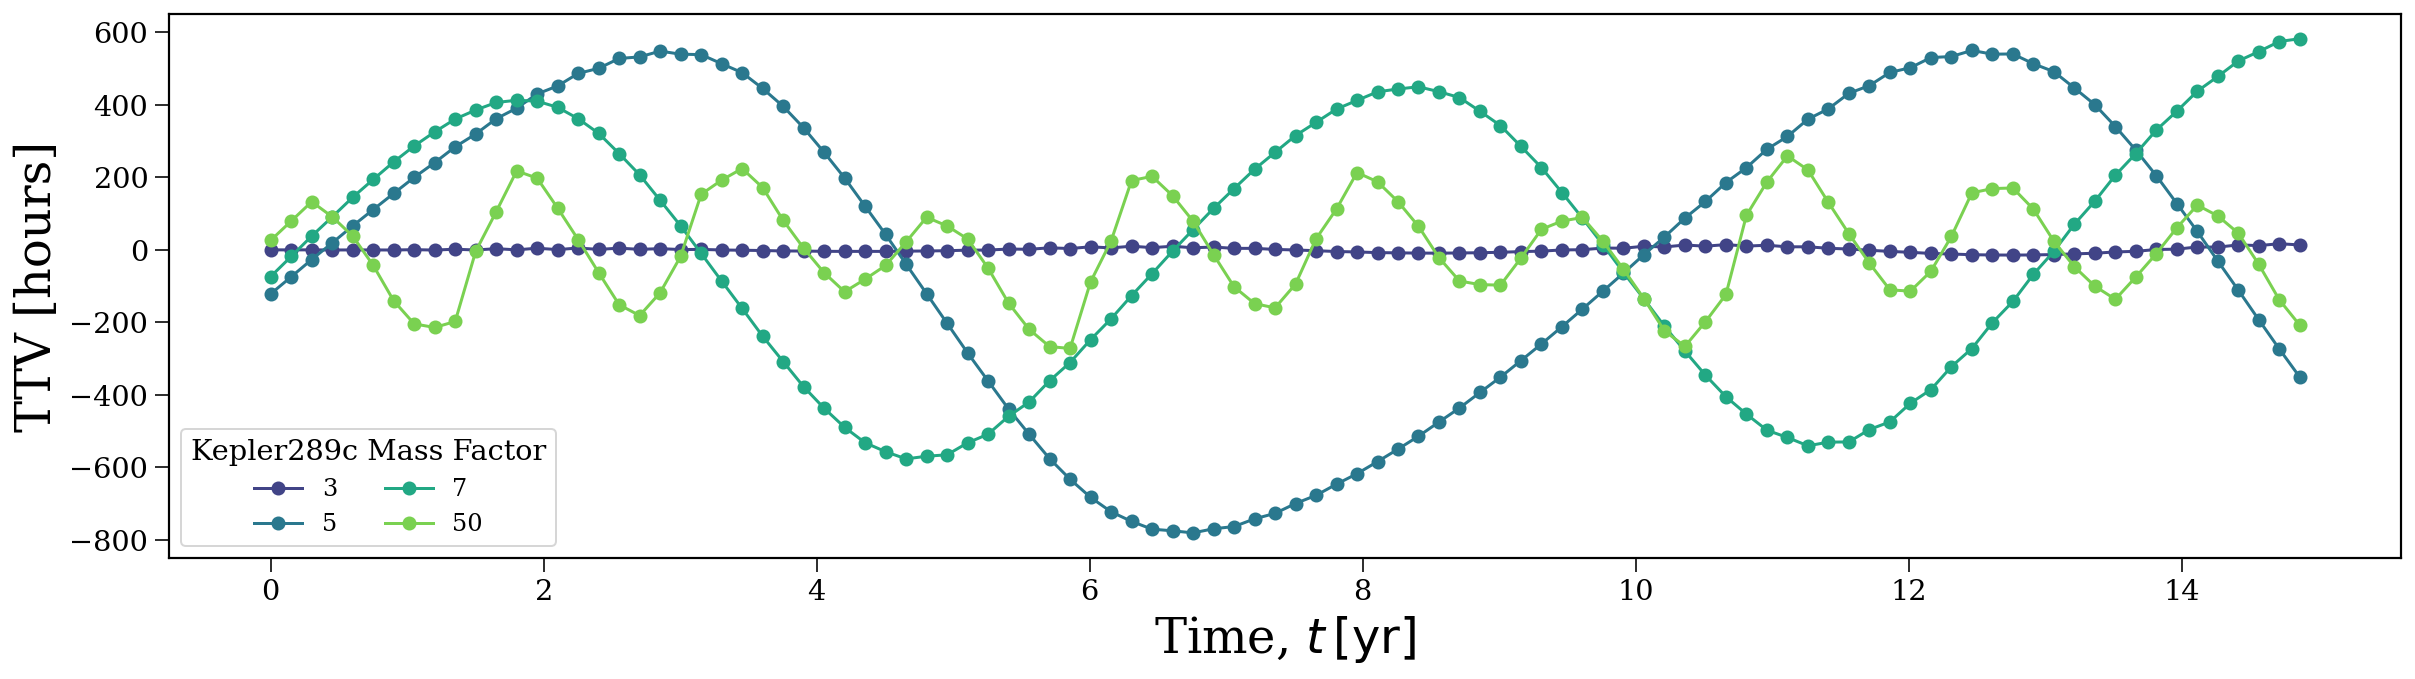

In [77]:
ttv_plot_mass_factors([3, 5, 7, 50], cmap="viridis")

Wow, check out the **HUGE** increase in TTVs between 3x to 5x. However, increasing past 5x to 7x and 50x seems to decrease the amplitude again. We *appear* to be hitting some sort of resonant behaviour here. I think that increasing the mass by a factor of 5 is making the orbits line up closely and leads to some huge changes in transit times.

## Summary of Mass Effects

Changing the mass of the larger planet doesn't change the period and affects the amplitude of the TTVs linearly *below a certain mass*. Once you go beyond some mass the outer planet starts to have more complex effects on the orbits that lead to very different TTVs.